In [38]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.interpolate as terp
import scipy.integrate as teg
import scipy

In [2]:
# grid constants
nx = 250
ny = 300
nz = 50
dx = 2000 # cell size in meters
dy = 2000

# physical constants
rhoConst = 1029 # ref density
tAlpha   = 0
sBeta    = 7.4e-4
g        = 9.81
s0       = 33
f0       = 1.4e-4
pdelta   = 4.4e-10
hDegLat  = 111000./2  # 0.5 deg lat in meters
hDegLon  = hDegLat * np.cos(2*np.pi*78/360)

## ECCO processing

This section is to load the ECCO data and perform the necessary
averaging.

In [3]:
# ecco data index constants
dVI   = -8   # chop the deepest 8 cells
myLat = 335 # index of southernmost latitude
myLon = 58  # index of westernmost longitude
monthList = list(range(1,13)) # months included in average

# index range
latRange = 8
lonRange = 33

In [4]:
# file i/o constants
locLoad = "/home/hcm7920/experiments/" # path to experiment directory
fname1  = "arcticMiddepthBI/data/eccoData/OCEAN_DENS_STRAT_PRESS_mon_mean_2017-"
fname2  = "_ECCO_V4r4_latlon_0p50deg.nc"

In [5]:
# load data for selected months
lats  = nc.Dataset(locLoad+fname1+f"01"+fname2)["latitude"][myLat:myLat+latRange]
lons  = nc.Dataset(locLoad+fname1+f"01"+fname2)["longitude"][myLon:myLon+lonRange]
depth = nc.Dataset(locLoad+fname1+f"01"+fname2)["Z"][:dVI]
numLevels, = depth.shape

dataArray1 = np.ma.zeros(shape=(len(monthList),numLevels,latRange,lonRange))
dataArray2 = np.ma.zeros(shape=(len(monthList),numLevels,latRange,lonRange))
for month in range(len(monthList)):
    dataArray1[month,:,:,:] = nc.Dataset(locLoad+fname1+f"{month+1:02}"+fname2
                                     )["RHOAnoma"][0,:dVI,myLat:myLat+latRange,myLon:myLon+lonRange]
    dataArray2[month,:,:,:] = nc.Dataset(locLoad+fname1+f"{month+1:02}"+fname2
                                     )["DRHODR"][0,:dVI,myLat:myLat+latRange,myLon:myLon+lonRange]

dataArray1.fill_value=np.nan
dataArray2.fill_value=np.nan

In [6]:
# time average
dataDensities = dataArray1.mean(0)
dataNSquares = dataArray2.mean(0) * g / rhoConst

In [7]:
# print lat and lon ranges
print(f"Longitude ranges from {lons[0]} to {lons[-1]}")
print(f"Latitude ranges from {lats[0]} to {lats[-1]}")

Longitude ranges from -150.75 to -134.75
Latitude ranges from 77.75 to 81.25


In [8]:
# an empty cell for testing
print(dataDensities.shape)
print(dataNSquares.shape)

(42, 8, 33)
(42, 8, 33)


In [9]:
# generate hydrostatic pressure field
pressure = np.zeros((nz+dVI,latRange,lonRange))
for i in range(50+dVI):
  pressure[i,:,:] = g * (rhoConst) * -depth[i]

In [10]:
# convert base density profile to potential density
dataDensities = rhoConst + dataDensities - rhoConst * pressure * pdelta

In [11]:
# calculate horizontal density gradients
meridGradDensities = (dataDensities[:,1:,:] - dataDensities[:,:-1,:]) / hDegLat
zonalGradDensities = (dataDensities[:,:,1:] - dataDensities[:,:,:-1]) / hDegLon

In [12]:
# space averages
dataNSquare      = dataNSquares.mean((1,2))
dataDensity      = dataDensities.mean((1,2))
meridGradDensity = meridGradDensities.mean((1,2))
zonalGradDensity = zonalGradDensities.mean((1,2))


In [13]:
# prophylaxis
dataDensity.fill_value = 0
dataNSquare.fill_value = 0
meridGradDensity.fill_value = 0
zonalGradDensity.fill_value = 0

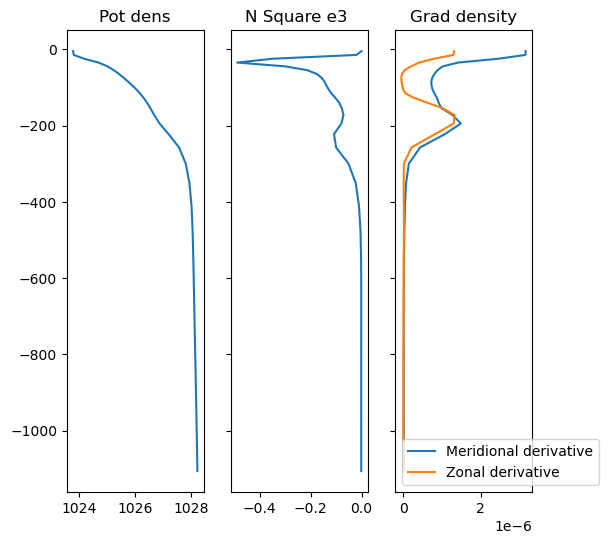

In [14]:
# plot the resulting profiles
fig,axs = plt.subplots(1,3,figsize=(6,6),sharey=True)
axs[0].plot(dataDensity[:30], depth[:30])
axs[0].set_title("Pot dens")
axs[1].plot(1e3*dataNSquare[:30], depth[:30], label="nSquare")
axs[1].set_title("N Square e3 ")
axs[2].plot(meridGradDensity[:30], depth[:30], label="Meridional derivative")
axs[2].plot(zonalGradDensity[:30], depth[:30], label="Zonal derivative")
axs[2].set_title("Grad density")
axs[2].legend()

## Regridding

This section is to generate the MITgcm model grid
and interpolate the ECCO profiles onto it.

In [15]:
# calculate relevant depth arrays from ECCO grid
zDeltaData = (depth[:-1]-depth[1:])
zHalfsData = (depth[:-1]+depth[1:])/2

In [16]:
# calculate interpolating splines from ECCO data
meridDGSpline = terp.splrep(-depth,meridGradDensity)
zonalDGSpline = terp.splrep(-depth,zonalGradDensity)
nSquareSpline = terp.splrep(-depth,dataNSquare)
baseRhoSpline = terp.splrep(-depth,dataDensity)

In [17]:
# generate model grid from ECCO grid
padSize = 50 - zDeltaData.shape[0] + 1
dz = np.pad(zDeltaData,(padSize,0),constant_values=10.)[:-1]
# dz.astype('>f4').tofile('eccoZCoordSpacingPadded.bin')

In [18]:
# calculate relevant depth arrays from model grid
zCenters = np.zeros((nz,))
zFaces   = np.zeros((nz,))
for i in range(50):
    zCenters[i] = dz[i]/2 + dz[:i].sum()
    zFaces[i]   = dz[:i+1].sum()

zDelta = (zCenters[1:]-zCenters[:-1])   # distance between centers
zHalfs = (zCenters[1:]+zCenters[:-1])/2 # depth @ between cell centers

In [19]:
# use spline to interpolate onto new grid
zonalDGHalfs  = terp.splev(zHalfs,zonalDGSpline)
zonalDG       = terp.splev(zCenters,zonalDGSpline)
meridDGHalfs  = terp.splev(zHalfs,meridDGSpline)
meridDG       = terp.splev(zCenters,meridDGSpline)
rhoProfile    = terp.splev(zCenters,baseRhoSpline)
nSquare       = terp.splev(zCenters,nSquareSpline)

## Model field initialization

This section generates the initial model fields
from the processed data.

In [20]:
# generate bump function for density field

# the conservative choice
def myBumpSech(x):
    center = nx / 2 # unit is grid cells
    width  = .4    # nonDim parameter
    return np.cosh((x-center) / (center*width))**(-2) # unit is grid cells

# the aggressive choice
def myBumpExp(x):
    center = nx / 2
    safety  = 1.01
    deg    = 2
    
    val = np.abs((x-center)/(center*safety))
    val = val**deg
    return np.exp(1-(1/(1-val)))

# make your choice .......................... here
funcPrime = np.fromfunction(lambda z,y,x: myBumpExp(x), shape=(nz,ny,nx))

In [21]:
# integrate bump function for density field
func  = teg.cumulative_trapezoid(funcPrime[0,0,:],
                                np.linspace(0,nx-1,nx),
                                initial=0)
func *= dx                                           # input: grid cells
func -= (func[int(nx/2)]+func[1+int(nx/2)])/2        # output: meters

In [22]:
# determine horizontal gradient of choice
horizDG = np.sqrt(zonalDG**2 + meridDG**2)
horizDGHalfs = np.sqrt(zonalDGHalfs**2 + meridDGHalfs**2)

In [23]:
# generate density field
rho  = np.ones((nz,ny,nx))*(rhoProfile[:,np.newaxis,np.newaxis] # for reshaping purposes
       +(horizDG[:,np.newaxis,np.newaxis]*func[np.newaxis,np.newaxis,:]))

In [24]:
# save u:
u = np.zeros((nz,ny,nx))
# u.astype('>f4').tofile('u-2km.bin')

In [25]:
# generate v from thermal wind balance: 0m/s at domain floor
vertiShear = -horizDGHalfs[:,np.newaxis,np.newaxis]*funcPrime[:-1,:,:]*g/rhoConst/f0 
velocities = np.zeros(shape=(nz,ny,nx))
for i in range(49,0,-1):
    velocities[i-1,:,:] = velocities[i,:,:] + vertiShear[i-1,:,:]*zDelta[i-1]
# velocities.astype('>f4').tofile('v-2km.bin')


In [26]:
# generate salinity field
salt = rho / rhoConst
salt = (salt-1) / sBeta
salt = salt + s0
# salt.astype('>f4').tofile('salt-2km.bin')

In [27]:
# generate perturbed salinity field
pSalt = salt + np.fromfunction(lambda z,y,x: 1e-4*np.sin(y/10), (nz,ny,nx))
# pSalt.astype('>f4').tofile('perturbedSalt-2km.bin')

In [28]:
# generate temp (not evolved in model)
temp = np.ones((nz,ny,nx))
# temp.astype('>f4').tofile('temp-2km.bin')

In [29]:
# generate SSH
eta  = (rho*dz[:,np.newaxis,np.newaxis]).sum(0) - rhoConst*dz.sum(0)
eta /= -rho[0,:,:]
eta += -eta.mean((0,1))
# eta.astype('>f4').tofile('eta-2km.bin')

In [30]:
# generate bathymetry
bathy = -1*np.ones((ny,nx))*dz.sum()
bathy[:,-1] = 0       # wall
# bathy.astype('>f4').tofile('bathy-2km.bin')

In [31]:
# generate restoring mask
mask = np.ones((nz,ny,nx))
# mask.astype('>f4').tofile('restore.bin')

In [32]:
# generate cice
concentration = 0.00 # float between 0 and 1
area = concentration * np.ones((ny,nx))
heff = area * 2 # effective thickness, (ice doesn't melt or grow!)
# area.astype('>f4').tofile("iceArea2km.bin")
# heff.astype('>f4').tofile("iceHeff2km.bin")

## View fields

This section contains some plots of the fields
that will initialize the model.

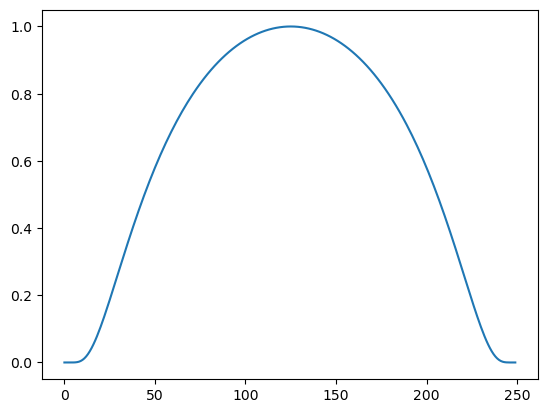

In [33]:
# view bump function
plt.plot(funcPrime[0,0,:])

Text(0.5, 1.0, 'Density section')

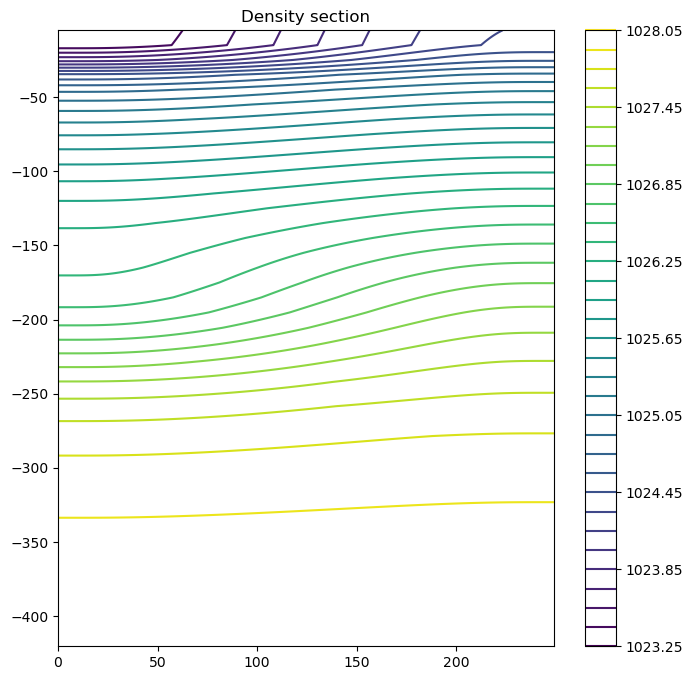

In [34]:
# view density field
plt.figure(figsize=(8,8))
plt.contour(np.linspace(0,249,250),-zCenters[:30],
            rho[:30,:,:].mean(1),40)
plt.colorbar()
plt.title("Density section")

Text(0.5, 1.0, 'Channel velocity section')

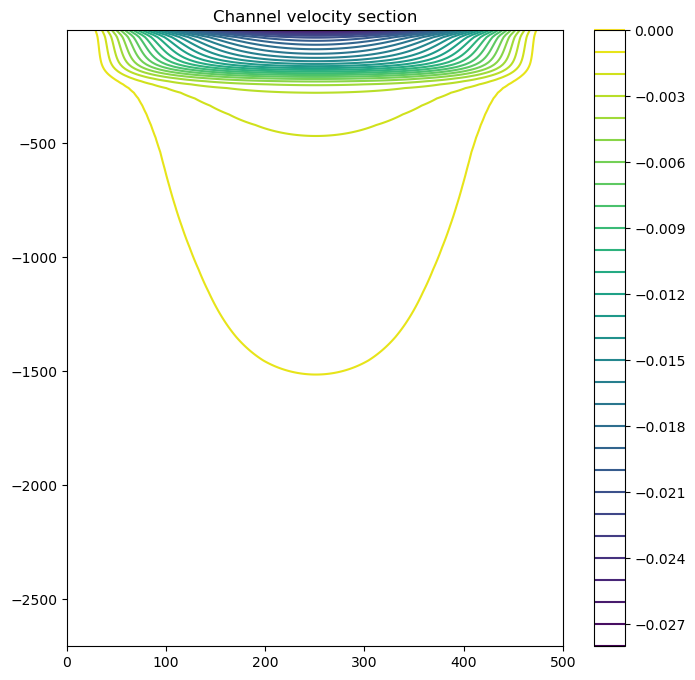

In [35]:
# view velocity field
plt.figure(figsize=(8,8))
plt.contour(np.linspace(0,500,250), -zCenters,
            velocities[:,:,:].mean(1), 30)
plt.colorbar()
plt.title("Channel velocity section")

## Save matlab fields

These blocks are to save certain fields in a matlab
format for use in the linear stability calculation.

In [39]:
# store arrays for future use
locS = "/home/hcm7920/experiments/arcticMiddepthBI/data/linStabData/"
saveDict = {}
saveDict["depth"] = zCenters
saveDict["rho"]   = rhoProfile
saveDict["uVel"]  = velocities[:, ny//2, nx//2]
saveDict["vVel"]  = velocities[:, ny//2, nx//2]*0.0
saveDict["bigF"]  = (f0**2) * rhoConst / g
saveDict["beta"]  = 0.0
saveDict["betaT"] = 0.0
scipy.io.savemat(locS+"modelProfilesForQgLinStab",saveDict)
del saveDict